In [4]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np


In [5]:
df = pd.read_csv("../data/cleaned_github_users.csv")  
df.head()

,Username,Name,Bio,Public_Repos,Followers,Following,Repositories,Languages,Location,Latitude,Longitude,Profile_URL,Languages_encoded,Location_encoded
0,mojombo,Tom Preston-Werner,No Bio Provided,0.037521,0.747329,0.002086,"30daysoflaptops.github.io, asteroids, benbalte...","CSS, JavaScript, C, Ruby, Scheme, TypeScript, ...",San Francisco,37.779259,-122.419329,https://github.com/mojombo,170,969
1,defunkt,Chris Wanstrath,🍔,0.060830,0.694782,0.040774,"ace, acts_as_textiled, ambition, ambitious_act...","JavaScript, Ruby, CoffeeScript, HTML, Emacs Li...",Unknown,0.000000,0.000000,https://github.com/defunkt,1876,1187
2,pjhyett,PJ Hyett,No Bio Provided,0.004548,0.257687,0.005689,"auto_migrations, blackjax, errcount, git-serve...","JavaScript, Ruby",Unknown,0.000000,0.000000,https://github.com/pjhyett,1871,1187
3,wycats,Yehuda Katz,No Bio Provided,0.169983,0.318037,0.002465,"2025-heroku-plans, abbot-from-scratch, abbot-n...","JavaScript, Rust, CSS, Ruby, CoffeeScript, She...","Portland, OR",45.520247,-122.674194,https://github.com/wycats,1968,866
4,ezmobius,Ezra Zygmuntowicz,No Bio Provided,0.012507,0.017712,0.002465,"acl_system2, bmhsearch, chef-101, chef-deploy,...","Perl, C, C++, Ruby",In the NW,0.000000,0.000000,https://github.com/ezmobius,2400,476


In [6]:
# Remove duplicate users
df.drop_duplicates(subset='Username', inplace=True)

# Remove users with no useful info (neither Languages nor Repositories)
df = df[~((df['Languages'] == 'Unknown') & (df['Repositories'] == 'Unknown'))]



In [7]:
df['combined_features'] = df['Languages'].fillna('') + ' ' + df['Repositories'].fillna('')


In [8]:
vectorizer = TfidfVectorizer(stop_words='english')
feature_matrix = vectorizer.fit_transform(df['combined_features'])


In [9]:
similarity_matrix = cosine_similarity(feature_matrix)

In [10]:
def recommend_partners(username, preferred_location=None, top_k=5):
    if username not in df['Username'].values:
        print("❌ Username not found.")
        return pd.DataFrame()

    idx = df.index[df['Username'] == username][0]
    user_similarities = similarity_matrix[idx]
    
    # Get top k similar users (excluding self)
    similar_indices = user_similarities.argsort()[::-1][1:top_k+10]  # buffer for location filter

    recommendations = df.iloc[similar_indices].copy()
    recommendations['similarity'] = user_similarities[similar_indices]

    # Optional: Location filter
    if preferred_location:
        recommendations = recommendations[recommendations['Location'].str.contains(preferred_location, case=False, na=False)]

    # Return top K
    return recommendations[['Username', 'Languages', 'Repositories', 'Location', 'Profile_URL', 'similarity']].head(top_k)


🔍 Recommendations for user: abhay
         Username                                          Languages  \
3097     Zenithar  XSLT, JavaScript, CSS, Go, Ruby, Python, Scala...   
83      freeformz        Go, Ruby, Python, Kotlin, HTML, Shell, VimL   
242           psi  JavaScript, Makefile, Go, Ruby, Python, Shell,...   
1772  sporkmonger  CSS, JavaScript, Go, Ruby, Python, C#, CoffeeS...   
241    adelcambre        CSS, JavaScript, Starlark, C++, Ruby, Shell   

                                           Repositories          Location  \
3097  action-gotestsum, aktarus, alpine-docker-build...  Toulouse, France   
83    2017-talks, adventOfCode, anonymous-slack, ans...      PDX Area, OR   
242   actions-sandbox, ale, amazon-eks-user-guide, c...  Philadelphia, PA   
1772  acts_as_xapian, addressable, alexa, autoparse,...   Minneapolis, MN   
241   99bottles, adelcambre.github.com, Adv360-Pro-Z...       Boulder, CO   

                         Profile_URL  similarity  
3097     https://gi

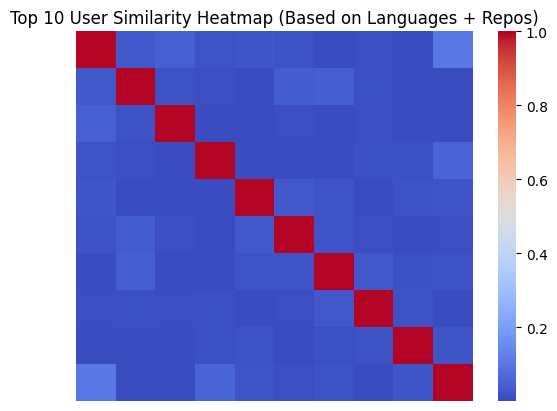

In [11]:
# Example usage
print("🔍 Recommendations for user: abhay")
print(recommend_partners('abhay'))

print("\n🔍 Recommendations for user: mojombo (filtered by location)")
print(recommend_partners('mojombo', preferred_location='San Francisco'))
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize similarity heatmap for top 10 users
sns.heatmap(similarity_matrix[:10, :10], cmap="coolwarm", xticklabels=False, yticklabels=False)
plt.title("Top 10 User Similarity Heatmap (Based on Languages + Repos)")
plt.show()


In [12]:
# Step: Save content-based similarity scores for all users
content_scores_df = pd.DataFrame({
    'Username': df['Username'],
    'content_score': similarity_matrix.max(axis=1)  # or use average if you prefer
})

# Save to CSV
content_scores_df.to_csv("../data/content_scores.csv", index=False)
print("✅ content_scores.csv saved.")


✅ content_scores.csv saved.


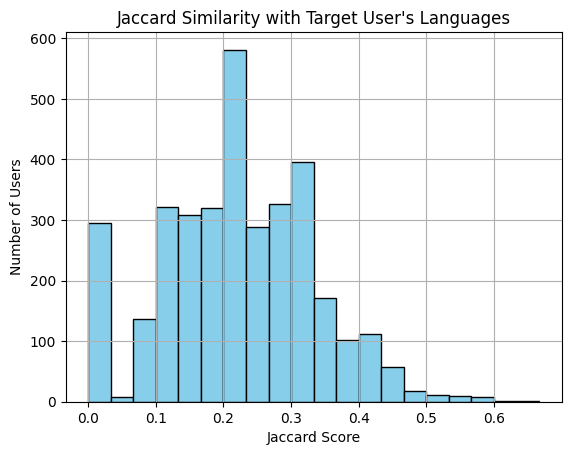

📊 Average Jaccard Similarity: 0.2176


In [13]:
import matplotlib.pyplot as plt

# Choose a sample user, e.g., 'abhay'
target_username = "abhay"

if target_username not in df['Username'].values:
    print(f"❌ User '{target_username}' not found in dataset.")
else:
    input_user = df[df['Username'] == target_username].iloc[0]
    input_langs = set(str(input_user['Languages']).split(", "))

    jaccard_scores = []

    for _, row in df.iterrows():
        if row['Username'] == target_username:
            continue
        user_langs = set(str(row['Languages']).split(", "))
        score = len(input_langs & user_langs) / (len(input_langs | user_langs) + 1e-5)
        jaccard_scores.append(score)

    import matplotlib.pyplot as plt

    # Plot similarity distribution
    plt.hist(jaccard_scores, bins=20, color='skyblue', edgecolor='black')
    plt.title("Jaccard Similarity with Target User's Languages")
    plt.xlabel("Jaccard Score")
    plt.ylabel("Number of Users")
    plt.grid(True)
    plt.show()

    print(f"📊 Average Jaccard Similarity: {sum(jaccard_scores)/len(jaccard_scores):.4f}")
